Pseudo code

<img src="images/q_learn.png" style="float: left;" width="600">

Directions:

1) initialize state S

For every step of the episode:

2) choose action A by some exploratory policy (e.g. ϵ-greedy) from state S

3) take action A and observe R and S′

4) do the update Q(S,A) = Q(S,A) + α(R+γ∗$\max_a$Q(S′,a) − Q(S,A))

5) update the state S=S′ and keep looping from step 2 until the end of episode

In [13]:
import numpy as np
from IPython.display import clear_output
import time

class QLearning:
    """
    QLearning reinforcement learning agent.

    Arguments:
      epsilon - (float) The probability of randomly exploring the action space
        rather than exploiting the best action.
      discount - (float) The discount factor. Controls the perceived value of
        future reward relative to short-term reward.
      adaptive - (bool) Whether to use an adaptive policy for setting
        values of epsilon during training
    """

    def __init__(self, epsilon=0.2, discount=0.95, adaptive=False):
        self.epsilon = epsilon
        self.discount = discount
        self.adaptive = adaptive

    def fit(self, env, steps=1000):
        state_action_values = np.zeros(
            (env.observation_space.n, env.action_space.n))
        N_actions_performed = np.zeros((env.action_space.n, ), dtype=int)
        state = env.reset()
        rewards = np.zeros((100, ))

        s = np.floor(steps / 100)
        s_count = 0
        reward_sum = 0
        idx = 0

        for step in range(steps):
            epsilon = self._get_epsilon(step / steps)
            # generate random num
            p = np.random.random()
            # check probability
            action = env.action_space.sample(
            )  # your agent here (this takes random actions)
            if p >= epsilon and len(set(state_action_values[state])) != 1:
                action = np.argmax(state_action_values[state])
            # take action and observe R, S'
            observation, reward, done, info = env.step(action)
            # update values
            N_actions_performed[action] += 1
            state_action_values[state][
                action] += 1 / N_actions_performed[action] * (
                    reward +
                    self.discount * max(state_action_values[observation]) -
                    state_action_values[state][action])
            reward_sum += reward
            # set next state
            state = observation
            # check s
            s_count += 1
            if s == s_count:
                rewards[idx] = reward_sum / (step + 1)
                s_count = 0
                idx += 1

            if done:
                state = env.reset()

        return state_action_values, rewards

    def predict(self, env, state_action_values):
        states, actions, rewards = [], [], []

        state = env.reset()
        env.render()
        time.sleep(0.3)

        while True:
            action = np.argmax(state_action_values[state])
            # take action and observe R, S'
            observation, reward, done, info = env.step(action)
            env.render()
            print(observation)
            time.sleep(0.3)
            # set next state
            state = observation
            # record data
            states.append(observation)
            actions.append(action)
            rewards.append(reward)

            if done:
                break

        return np.array(states), np.array(actions), np.array(rewards)

    def _get_epsilon(self, progress):
        return self._adaptive_epsilon(
            progress) if self.adaptive else self.epsilon

    def _adaptive_epsilon(self, progress):
        return (1 - progress) * self.epsilon


beginning trial 1
beginning trial 2
beginning trial 3
beginning trial 4
beginning trial 5
beginning trial 6
beginning trial 7
beginning trial 8
beginning trial 9
beginning trial 10


<IPython.core.display.Javascript object>


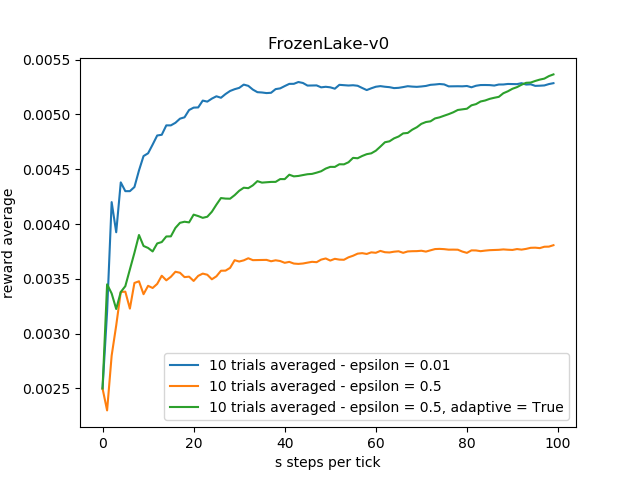

In [19]:
import gym
%matplotlib notebook
import matplotlib.pyplot as plt

s_trials = []
b_trials = []
g_trials = []
env = gym.make('FrozenLake-v0')

for i in range(10):
    print(f'beginning trial {i + 1}')
    agent = QLearning(epsilon=0.01)
    action_values, rewards = agent.fit(env, steps = 100000)
    s_trials.append(rewards)

    agent = QLearning(epsilon=0.5)
    action_values, rewards = agent.fit(env, steps = 100000)
    b_trials.append(rewards)

    agent = QLearning(epsilon=0.5, adaptive=True)
    action_values, rewards = agent.fit(env, steps = 100000)
    g_trials.append(rewards)

## plotting
plt.plot(np.average(s_trials[:10], axis=0), label='10 trials averaged - epsilon = 0.01')
plt.plot(np.average(b_trials[:10], axis=0), label='10 trials averaged - epsilon = 0.5')
plt.plot(np.average(g_trials[:10], axis=0), label='10 trials averaged - epsilon = 0.5, adaptive = True')
plt.title('FrozenLake-v0')
plt.xlabel('s steps per tick')
plt.ylabel('reward average')
plt.legend()
plt.show()